In [1]:
import torch
device = torch.device("cuda:0")
dataset_type = "CIFAR10"
model_name = "ResNet20"


In [2]:
import sys
python_files_dir = "./python_files/" # python工具包位置
sys.path.append(python_files_dir)


model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as all_model


import copy
import pickle
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
# from openTSNE import TSNE
import matplotlib.pyplot as plt
import copy
# import pandas as pd
# import seaborn as sns
import random

import torch
import torch.nn as nn
import torchvision
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset

# import h5py


In [14]:
from torchvision.transforms.functional import normalize, resize, to_pil_image
# 看一下这一批数据对应哪个原始图片-----random_50k_png


# data_z_path = "./static/data/CIFAR10/latent_z/BigGAN_random_png_208z_50000_2023-08-30.pt"
#
# # data_z_path = "./static/data/CIFAR10/latent_z/BigGAN_208z_50000.pt"
# dict_zs = torch.load(data_z_path, map_location="cpu")  # 因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错
# print(dict_zs.shape)
# checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=392000.pth"
# G = BigGAN.Generator().to(device)
# G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
# G.eval()
#
# for i in range(10):
#     z = dict_zs[i].unsqueeze(0).to(device)
#     print(z.shape)
#     img = G(z)
#     img = ((img + 1)/2).clamp(0.0, 1.0)
#     utils.save_image(img.detach().cpu(), 'temp/pic/random_50k' + '/pic_' + str(i) + '.png')


# 后128代表类别，输出后发现是相同的。
data_z_path = "E:/project/lantentspace/static/data/CIFAR10/latent_z/BigGAN_random_png_208z_50000_2023-08-30.pt"
label_path = "E:/project/lantentspace/static/data/CIFAR10/labels/BigGAN_random_png_208z_50000_2023-08-30_labels.pt"

dict_zs = torch.load(data_z_path, map_location="cpu")  # 因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错
data_z_labels = torch.load(label_path, map_location="cpu")
# 将潜在向量和标签转换为列表
# latent_zs = list(dict_zs.values())
# labels = list(data_z_labels.values())
# 指定类别
specified_category = 0  # 修改为你感兴趣的类别

# 找到指定类别的潜在向量
specified_category_zs = dict_zs[data_z_labels == specified_category]

# 提取10个样本
sampled_zs = specified_category_zs[:10]

# 输出这10个样本的后128个元素
for i, z in enumerate(sampled_zs):
    print(f"样本 {i + 1} 的后128个元素：")
    print(z[-128:])


In [ ]:
from AE import Mydata_sets
import model_files as model_all


if dataset_type == "CIFAR10":
    transform = transforms.Compose([
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
        # transforms.Resize((224, 224), interpolation=Image.BICUBIC),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
ResNet50 = model_all.get_DNN_model(dataset_type, model_name)
ResNet50.load_state_dict( torch.load("./model_files/CIFAR10/checkpoints/classify_model/ResNet20.pt", map_location=device)) # 这个pt文件里不仅仅是参数，包括了模型
# ResNet50 = torch.load("./model_files/CIFAR10/checkpoints/classify_model/ResNet50.pt", map_location=device)
ResNet50 = ResNet50.to(device)
ResNet50.eval()




pic_path = "./static/data/CIFAR10/pic/random_50k_png"


features, labels, max_values, ids, ten_Ds, picture = [], [], [], [], [], [] # features：提取的2048维图片特征，labels：模型预测的标签，ids图片文件编号

feature_model = copy.deepcopy(ResNet50)
feature_model.fc = nn.Identity() # 相当于取消fc层, 这样
label_model = copy.deepcopy(ResNet50)


img_datasets = Mydata_sets(pic_path, transform=transform)
# img_datasets = torchvision.datasets.CIFAR10("./static/data/CIFAR10/", train=True, download=False, transform=transform) #使用原始的cifar10图片
imgLoader = torch.utils.data.DataLoader(img_datasets, batch_size=32, shuffle=False, num_workers=0)  # 指定读取配置信息

with torch.no_grad():
    for x, y in tqdm(imgLoader):
        x = x.to(device)
        ids.append(y)  # N

        feature = feature_model(x)  # N, 2048
        features.append(feature)
        picture.append(x)

        ten_D = label_model(x)
        max_value, label = torch.max(ten_D, dim=1)
        # label = torch.argmax(ten_D, dim=1)
        ten_Ds.append(ten_D)
        labels.append(label)
        max_values.append(max_value)
print(picture.shape)
picture = torch.cat(picture, dim=0).squeeze().view(50000,-1).cpu().numpy()
ten_Ds = torch.cat(ten_Ds, dim=0).squeeze().cpu().numpy()  # (n, 2048)
features = torch.cat(features, dim=0).squeeze().cpu().numpy()  # (n, 2048)
labels = torch.cat(labels, dim=0).squeeze().cpu().numpy()  # n
max_values = torch.cat(max_values, dim=0).squeeze().cpu().numpy()  # n
ids = torch.cat(ids, dim=0).cpu().numpy() # n

print(picture.shape)
print(features.shape)
print(labels.shape)
print(max_values.shape)
print(ids.shape)
print(ten_Ds.shape)
np.save('./temp/pic/AE/features_20.npy', features)
np.save('./temp/pic/AE/labels_20.npy', labels)
np.save('./temp/pic/AE/max_values_20.npy', max_values)
np.save('./temp/pic/AE/ids_20.npy', ids)
np.save('./temp/pic/AE/ten_feature_20.npy', ten_Ds)
np.save('./temp/pic/AE/picture_20.npy', picture)


In [ ]:
from torch import optim
from AE import AutoencoderWithAttributeLoss, CustomLoss, Mydata_sets1
import numpy as np

# 加载numpy数组
# loaded_features = np.load('./temp/pic/AE/features.npy')
# loaded_labels = np.load('./temp/pic/AE/labels.npy')
# loaded_max_values = np.load('./temp/pic/AE/max_values.npy')
# loaded_ids = np.load('./temp/pic/AE/ids.npy')
# loaded_ten = np.load('./temp/pic/AE/ten_feature.npy')
# picture = np.load('./temp/pic/AE/picture.npy')
loaded_features = np.load('./temp/pic/AE/features_20.npy')
loaded_labels = np.load('./temp/pic/AE/labels_20.npy')
loaded_max_values = np.load('./temp/pic/AE/max_values_20.npy')
loaded_ids = np.load('./temp/pic/AE/ids_20.npy')
loaded_ten = np.load('./temp/pic/AE/ten_feature_20.npy')
picture = np.load('./temp/pic/AE/picture_20.npy')

# 分等级
# # 找到最小值和最大值
min_value = np.min(loaded_max_values)
# max_value = np.max(loaded_max_values)
#
# # 计算区间宽度
# interval_width = (max_value - min_value) / 5
#
# # 将值分成五个区间并生成相应的等级数组
# level_array = np.zeros_like(loaded_max_values, dtype=int)
# for i in range(5):
#     lower_bound = min_value + i * interval_width
#     upper_bound = min_value + (i + 1) * interval_width
#     indices = np.logical_and(loaded_max_values >= lower_bound, loaded_max_values < upper_bound)
#     level_array[indices] = i
# 计算每个区间的阈值
# 对样本按照最大值进行排序

sorted_values = np.sort(loaded_max_values)

# 初始化等级数组
level_array = np.zeros_like(loaded_max_values, dtype=int)

num_samples = len(loaded_max_values)
num_intervals = 5
samples_per_interval = num_samples // num_intervals
thresholds = [sorted_values[i * samples_per_interval] for i in range(1, num_intervals)]

# 考虑最小值，确保每个区间都包含最小值
thresholds = [min_value] + thresholds

# 根据阈值将样本划分到对应的区间
for i, threshold in enumerate(thresholds[:-1]):
    level_array[(loaded_max_values >= threshold) & (loaded_max_values < thresholds[i+1])] = i

# 最后一个区间的样本划分为最大值的区间
level_array[loaded_max_values >= thresholds[-1]] = num_intervals - 1
# print(level_array)



input_data = torch.tensor(picture, dtype=torch.float32).to(device)
# confidence = torch.tensor(loaded_ten, dtype=torch.float32)
confidence = torch.tensor(level_array, dtype=torch.float32).to(device)
# 初始化自动编码器模型
autoencoder = AutoencoderWithAttributeLoss(input_dim=input_data.shape[1], encoding_dim=32).to(device)
# autoencoder.load_state_dict(torch.load('./temp/pic/AE/autoencoder_model_use_image.pth'))

criterion = CustomLoss()

# 设置优化器
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# 训练模型
num_epochs = 150
batch_size = 128
for epoch in range(num_epochs):
    for i in range(0, len(input_data), batch_size):
        optimizer.zero_grad()
        batch_input = input_data[i:i+batch_size]
        batch_confidence = confidence[i:i+batch_size]
        # print(batch_input.shape,batch_confidence.shape)
        # reconstructed, attribute_output = autoencoder(batch_input)
        attribute_output, reconstructed = autoencoder(batch_input)
        # print(reconstructed.shape,attribute_output.shape)
        # attribute_output = attribute_output.unsqueeze(1)  # 扩展维度
        # batch_confidence = batch_confidence.unsqueeze(1)  # 扩展维度
        # attribute_output = attribute_output.long()
        batch_confidence = batch_confidence.long()
        # print(attribute_output.shape,batch_confidence.shape)
        loss, recon_loss, attribute_loss = criterion(reconstructed, batch_input, attribute_output, batch_confidence)
        # loss = criterion(reconstructed, batch_input, attribute_output, batch_confidence)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Reconstruction Loss: {recon_loss.item()}, Attribute Loss: {attribute_loss.item()}")
    # print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# img_datasets = Mydata_sets1(pic_path,level_array, transform = transforms.Compose([
#         transforms.PILToTensor(),
#         transforms.ConvertImageDtype(torch.float),
#         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     ]))
# # img_datasets = torchvision.datasets.CIFAR10("./static/data/CIFAR10/", train=True, download=False, transform=transform) #使用原始的cifar10图片
# imgLoader = torch.utils.data.DataLoader(img_datasets, batch_size=64, shuffle=False, num_workers=4)  # 指定读取配置信息
#
# for epoch in range(num_epochs):
#     for x, y, z in tqdm(imgLoader):
#         optimizer.zero_grad()
#         batch_input = x
#         batch_confidence = z
#         # print(batch_input.shape,batch_confidence.shape)
#         # reconstructed, attribute_output = autoencoder(batch_input)
#         attribute_output, reconstructed = autoencoder(batch_input)
#         # print(reconstructed.shape,attribute_output.shape)
#         # attribute_output = attribute_output.unsqueeze(1)  # 扩展维度
#         # batch_confidence = batch_confidence.unsqueeze(1)  # 扩展维度
#         # attribute_output = attribute_output.long()
#         batch_confidence = batch_confidence.long()
#         # print(attribute_output.shape,batch_confidence.shape)
#         loss, recon_loss, attribute_loss = criterion(reconstructed, batch_input, attribute_output, batch_confidence)
#         # loss = criterion(reconstructed, batch_input, attribute_output, batch_confidence)
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1}, Reconstruction Loss: {recon_loss.item()}, Attribute Loss: {attribute_loss.item()}")


In [5]:

# 使用正负置信度进行降维
from AE import Mydata_sets2
import model_files as model_all
ResNet20 = model_all.get_DNN_model(dataset_type, model_name)
ResNet20.load_state_dict( torch.load("./model_files/CIFAR10/checkpoints/classify_model/ResNet20.pt", map_location=device)) # 这个pt文件里不仅仅是参数，包括了模型
# ResNet50 = torch.load("./model_files/CIFAR10/checkpoints/classify_model/ResNet50.pt", map_location=device)
ResNet20 = ResNet20.to(device)
ResNet20.eval()


feature_model = copy.deepcopy(ResNet20)
feature_model.fc = nn.Identity() # 相当于取消fc层, 这样


checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=392000.pth"  # kjl测试#############
global G
print("数据类型为：", dataset_type)
G = model_all.get_generative_model("CIFAR10").to(device)
G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
G.eval()

data_z_path = "./static/data/CIFAR10/latent_z/BigGAN_random_png_208z_50000_2023-08-30.pt"
label_path = "./static/data/CIFAR10/labels/BigGAN_random_png_208z_50000_2023-08-30_labels.pt"
dict_zs = torch.load(data_z_path, map_location="cpu")  # 因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错
data_z_labels = torch.load(label_path,map_location="cpu")

zs_datasets = Mydata_sets2(dict_zs,data_z_labels)
    # 不需要前向传播，一次可以多处理一些
zs_loader = DataLoader(zs_datasets, batch_size=32, shuffle=False, num_workers=0)  # 指定读取配置信息


features, labels, max_values, ids, ten_Ds, picture = [], [], [], [], [], [] # features：提取的2048维图片特征，labels：模型预测的标签，ids图片文件编号

with torch.no_grad():  # 取消梯度计算，加快运行速度
    for batch_z, batch_labels in zs_loader:
        # z = torch.tensor(batch_z, dtype=torch.float32, device=device).detach()
        z = torch.tensor(batch_z).to(torch.float32).to(device).detach()  # latent code
        imgs = G(z)

        feature = feature_model(imgs)  # N, 2048
        features.append(feature)
        # DNN_model.layer3.register_forward_hook(get_activation('layer3'))
        layers = ResNet20(imgs)  # 分类模型分类图片
        # CAMlayer = activation['layer3']
        max_value, label = torch.max(layers, dim=1)
        same_labels_mask = torch.eq(label, batch_labels.to(device))
        # 将不同标签对应的置信度设为负值
        max_value = torch.where(same_labels_mask, max_value, -max_value)
        picture.append(imgs)
        # label = torch.argmax(ten_D, dim=1)
        ten_Ds.append(layers)
        labels.append(label)
        max_values.append(max_value)

picture = torch.cat(picture, dim=0).squeeze().view(50000,-1).cpu().numpy()
ten_Ds = torch.cat(ten_Ds, dim=0).squeeze().cpu().numpy()  # (n, 10)
features = torch.cat(features, dim=0).squeeze().cpu().numpy()  # (n, 2048)
labels = torch.cat(labels, dim=0).squeeze().cpu().numpy()  # n
max_values = torch.cat(max_values, dim=0).squeeze().cpu().numpy()  # n
# ids = torch.cat(ids, dim=0).cpu().numpy() # n


数据类型为： CIFAR10


C:\Users\charon\AppData\Local\Temp\ipykernel_19232\1952229006.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(batch_z).to(torch.float32).to(device).detach()  # latent code


In [6]:
# 保存numpy数组到文件
np.save('./temp/pic/AE_conf+_/labels.npy', labels)
np.save('./temp/pic/AE_conf+_/max_values.npy', max_values)
np.save('./temp/pic/AE_conf+_/ten_feature.npy', ten_Ds)
np.save('./temp/pic/AE_conf+_/picture.npy', picture)
np.save('./temp/pic/AE_conf+_/features.npy', features)

In [8]:
print(features.shape)

(50000, 64)


In [9]:
from torch import optim
from AE import AutoencoderWithAttributeLoss, CustomLoss, Mydata_sets1
import numpy as np

# 加载numpy数组
# loaded_features = np.load('./temp/pic/AE/features.npy')
# loaded_labels = np.load('./temp/pic/AE/labels.npy')
# loaded_max_values = np.load('./temp/pic/AE/max_values.npy')
# loaded_ids = np.load('./temp/pic/AE/ids.npy')
# loaded_ten = np.load('./temp/pic/AE/ten_feature.npy')
# picture = np.load('./temp/pic/AE/picture.npy')
loaded_labels = np.load('./temp/pic/AE_conf+_/labels.npy')
loaded_max_values = np.load('./temp/pic/AE_conf+_/max_values.npy')
# loaded_ids = np.load('./temp/pic/AE/ids_20.npy')
loaded_ten = np.load('./temp/pic/AE_conf+_/ten_feature.npy')
picture = np.load('./temp/pic/AE_conf+_/picture.npy')
features = np.load('./temp/pic/AE_conf+_/features.npy')

# 分等级
# # 找到最小值和最大值
min_value = np.min(loaded_max_values)
# max_value = np.max(loaded_max_values)
#
# # 计算区间宽度
# interval_width = (max_value - min_value) / 5
#
# # 将值分成五个区间并生成相应的等级数组
# level_array = np.zeros_like(loaded_max_values, dtype=int)
# for i in range(5):
#     lower_bound = min_value + i * interval_width
#     upper_bound = min_value + (i + 1) * interval_width
#     indices = np.logical_and(loaded_max_values >= lower_bound, loaded_max_values < upper_bound)
#     level_array[indices] = i
# 计算每个区间的阈值
# 对样本按照最大值进行排序

sorted_values = np.sort(loaded_max_values)

# 初始化等级数组
level_array = np.zeros_like(loaded_max_values, dtype=int)

num_samples = len(loaded_max_values)
num_intervals = 10
samples_per_interval = num_samples // num_intervals
thresholds = [sorted_values[i * samples_per_interval] for i in range(1, num_intervals)]

# 考虑最小值，确保每个区间都包含最小值
thresholds = [min_value] + thresholds

# 根据阈值将样本划分到对应的区间
for i, threshold in enumerate(thresholds[:-1]):
    level_array[(loaded_max_values >= threshold) & (loaded_max_values < thresholds[i+1])] = i

# 最后一个区间的样本划分为最大值的区间
level_array[loaded_max_values >= thresholds[-1]] = num_intervals - 1
# print(level_array)



# input_data = torch.tensor(picture, dtype=torch.float32).to(device)
input_data = torch.tensor(features, dtype=torch.float32).to(device)
# confidence = torch.tensor(loaded_ten, dtype=torch.float32)
confidence = torch.tensor(level_array, dtype=torch.float32).to(device)
# 初始化自动编码器模型
autoencoder = AutoencoderWithAttributeLoss(input_dim=input_data.shape[1], encoding_dim=16).to(device)
# autoencoder.load_state_dict(torch.load('./temp/pic/AE/autoencoder_model_use_image.pth'))

criterion = CustomLoss()

# 设置优化器
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# 训练模型
num_epochs = 150
batch_size = 128
for epoch in range(num_epochs):
    for i in range(0, len(input_data), batch_size):
        optimizer.zero_grad()
        batch_input = input_data[i:i+batch_size]
        batch_confidence = confidence[i:i+batch_size]
        # print(batch_input.shape,batch_confidence.shape)
        # reconstructed, attribute_output = autoencoder(batch_input)
        attribute_output, reconstructed = autoencoder(batch_input)
        # print(reconstructed.shape,attribute_output.shape)
        # attribute_output = attribute_output.unsqueeze(1)  # 扩展维度
        # batch_confidence = batch_confidence.unsqueeze(1)  # 扩展维度
        # attribute_output = attribute_output.long()
        batch_confidence = batch_confidence.long()
        # print(attribute_output.shape,batch_confidence.shape)
        loss, recon_loss, attribute_loss = criterion(reconstructed, batch_input, attribute_output, batch_confidence)
        # loss = criterion(reconstructed, batch_input, attribute_output, batch_confidence)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Reconstruction Loss: {recon_loss.item()}, Attribute Loss: {attribute_loss.item()}")
    # print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# img_datasets = Mydata_sets1(pic_path,level_array, transform = transforms.Compose([
#         transforms.PILToTensor(),
#         transforms.ConvertImageDtype(torch.float),
#         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     ]))
# # img_datasets = torchvision.datasets.CIFAR10("./static/data/CIFAR10/", train=True, download=False, transform=transform) #使用原始的cifar10图片
# imgLoader = torch.utils.data.DataLoader(img_datasets, batch_size=64, shuffle=False, num_workers=4)  # 指定读取配置信息
#
# for epoch in range(num_epochs):
#     for x, y, z in tqdm(imgLoader):
#         optimizer.zero_grad()
#         batch_input = x
#         batch_confidence = z
#         # print(batch_input.shape,batch_confidence.shape)
#         # reconstructed, attribute_output = autoencoder(batch_input)
#         attribute_output, reconstructed = autoencoder(batch_input)
#         # print(reconstructed.shape,attribute_output.shape)
#         # attribute_output = attribute_output.unsqueeze(1)  # 扩展维度
#         # batch_confidence = batch_confidence.unsqueeze(1)  # 扩展维度
#         # attribute_output = attribute_output.long()
#         batch_confidence = batch_confidence.long()
#         # print(attribute_output.shape,batch_confidence.shape)
#         loss, recon_loss, attribute_loss = criterion(reconstructed, batch_input, attribute_output, batch_confidence)
#         # loss = criterion(reconstructed, batch_input, attribute_output, batch_confidence)
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1}, Reconstruction Loss: {recon_loss.item()}, Attribute Loss: {attribute_loss.item()}")


Epoch 1, Reconstruction Loss: 0.17630138993263245, Attribute Loss: 0.9517108201980591
Epoch 2, Reconstruction Loss: 0.15084229409694672, Attribute Loss: 0.8196824193000793
Epoch 3, Reconstruction Loss: 0.142140194773674, Attribute Loss: 0.7168808579444885
Epoch 4, Reconstruction Loss: 0.13893090188503265, Attribute Loss: 0.6411150693893433
Epoch 5, Reconstruction Loss: 0.13304290175437927, Attribute Loss: 0.5846787691116333
Epoch 6, Reconstruction Loss: 0.13107429444789886, Attribute Loss: 0.5545009970664978
Epoch 7, Reconstruction Loss: 0.12971122562885284, Attribute Loss: 0.5309873223304749
Epoch 8, Reconstruction Loss: 0.12976089119911194, Attribute Loss: 0.5205259919166565
Epoch 9, Reconstruction Loss: 0.1284898817539215, Attribute Loss: 0.5269996523857117
Epoch 10, Reconstruction Loss: 0.12623021006584167, Attribute Loss: 0.5163878202438354
Epoch 11, Reconstruction Loss: 0.1248650774359703, Attribute Loss: 0.5005155801773071
Epoch 12, Reconstruction Loss: 0.1292448341846466, Attri

In [10]:
# 保存模型
# torch.save(autoencoder.state_dict(), './temp/pic/AE/autoencoder_model.pth')
# 图片原始输入，resnet50,10个档次，只有置信度损失
# torch.save(autoencoder.state_dict(), './temp/pic/AE/autoencoder_model_use_image.pth')
# 图片原始输入，resnet20,5个档次，0.1：1
torch.save(autoencoder.state_dict(), './temp/pic/AE_conf+_/autoencoder_model_use_image_20.pth')

print(thresholds)


[-18.461071, -6.457718, -4.0984583, 5.2606506, 6.9484186, 8.260223, 9.437554, 10.619406, 11.9404, 13.802137]


In [12]:
# # 图片的tensor数据
# import pandas as pd
# from torch import optim
# from AE import AutoencoderWithAttributeLoss, CustomLoss, Mydata_sets
# import numpy as np
# pic_path = "./static/data/CIFAR10/pic/random_50k_png"
#
# img_datasets = Mydata_sets(pic_path, transform = transforms.Compose([
#         transforms.PILToTensor(),
#         transforms.ConvertImageDtype(torch.float),
#         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     ]))
# # img_datasets = torchvision.datasets.CIFAR10("./static/data/CIFAR10/", train=True, download=False, transform=transform) #使用原始的cifar10图片
# imgLoader = torch.utils.data.DataLoader(img_datasets, batch_size=64, shuffle=False, num_workers=4)  # 指定读取配置信息
#
# input_data=[]
# indexs = []
# for x, y in tqdm(imgLoader):
#     # print(x.shape, z.shape)
#
#     input_data.append(x)
#     indexs.append(y)
# input_data = torch.cat(input_data, dim=0).squeeze().view(50000,-1).cpu().numpy()
# indexs = torch.cat(indexs, dim=0).squeeze().cpu().numpy()
# print(input_data.shape, indexs.shape)
#


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:12<00:00, 60.75it/s]


(50000, 3072) (50000,)


In [12]:
# from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from openTSNE import TSNE
import torch.nn.functional as F
# tree_2D_path = "./static/data/CIFAR10/2D_kdTree/2D_kdTree_50000_png_2023-08-30.pt"
# tree_2D = torch.load(tree_2D_path)
# print(tree_2D.shape)
# 加载模型
# input_data = torch.tensor(input_data, dtype=torch.float32)

loaded_autoencoder = AutoencoderWithAttributeLoss(input_dim=input_data.shape[1], encoding_dim=16).to(device)
# loaded_autoencoder.load_state_dict(torch.load('./temp/pic/AE/autoencoder_model_use_image.pth'))
loaded_autoencoder.load_state_dict(torch.load('./temp/pic/AE_conf+_/autoencoder_model_use_image_20.pth'))
loaded_autoencoder.eval()  # 设置模型为评估模式，这会关闭 dropout 和 batch normalization




with torch.no_grad():
    encoded_output = loaded_autoencoder.encoder(input_data)
print(encoded_output.shape)
# encoded_output = F.normalize(encoded_output, p=2, dim=1)
# print(encoded_output[:5])
embed = TSNE(n_jobs=4).fit(encoded_output.cpu())  # N, 2



torch.Size([50000, 16])


In [17]:
# loaded_features = np.load('./temp/pic/AE/features.npy')

# embed = TSNE(n_jobs=4).fit(loaded_ten)

In [13]:
import pandas as pd

pd_embed = pd.DataFrame(embed)
print(pd_embed.shape)

np.save('./temp/pic/AE_conf+_/embed_2dim.npy', pd_embed)

(50000, 2)


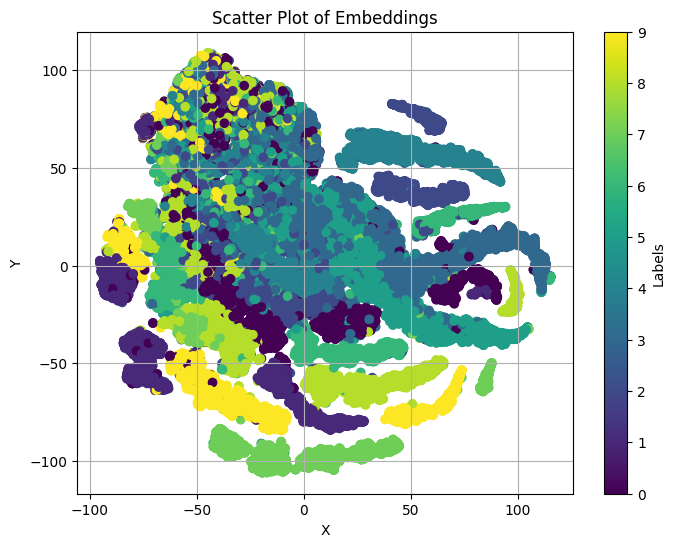

In [15]:
# 找到每个维度的最小值和最大值
# min_x, min_y = np.min(pd_embed, axis=0)
# max_x, max_y = np.max(pd_embed, axis=0)
#
# # 缩放坐标到0到1的范围内
# pd_embed = (pd_embed - [min_x, min_y]) / [max_x - min_x, max_y - min_y]
# print(pd_embed.shape)
#
# x = pd_embed.iloc[:, 0]
# y = pd_embed.iloc[:, 1]
x = pd_embed.iloc[:, 0]
y = pd_embed.iloc[:, 1]
# loaded_labels = np.load('./temp/pic/AE/labels.npy')

# 绘制二维散点图
plt.figure(figsize=(8, 6))
# plt.scatter(x, y, c=loaded_labels, cmap='viridis')
plt.scatter(x, y, c=level_array, cmap='viridis')
plt.colorbar(label='Labels')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Embeddings')
plt.grid(True)
plt.show()

In [14]:

from scipy import spatial
pd_embed = np.load('./temp/pic/AE_conf+_/embed_2dim.npy')

print(pd_embed[:5])
# pd_embed.columns=["x", "y"]
# print(pd_embed[:5])
# loaded_labels = np.load('./temp/pic/AE_conf+_/labels.npy')
# pd_embed.insert(loc=2, column='label', value=loaded_labels)
# print(pd_embed[:5])
# idx_to_class = ["airplane", "automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
# pd_embed['label'] = pd_embed['label'].apply(lambda x: idx_to_class[int(x)])
# print(pd_embed[:5])

# 找到每个维度的最小值和最大值
min_x, min_y = np.min(pd_embed, axis=0)
max_x, max_y = np.max(pd_embed, axis=0)

# 缩放坐标到0到1的范围内
scaled_value = (pd_embed - [min_x, min_y]) / [max_x - min_x, max_y - min_y]

print("Scaled Coordinates:\n", scaled_value[:5])

tree = spatial.KDTree(data=scaled_value)

# torch.save(tree, "./static/data/CIFAR10/2D_kdTree/2D_kdTree_50000_png_2024-3-25.pt")
torch.save(tree, "./static/data/CIFAR10/2D_kdTree/2D_kdTree_50000_png_2024-3-27_cof.pt")


[[ 11.87965707 -85.63638773]
 [ 47.72966413 -74.14105326]
 [ 34.962259    31.70732307]
 [-11.24553171   9.49849222]
 [ 81.48093401 -19.59175444]]
Scaled Coordinates:
 [[0.56208512 0.0344915 ]
 [0.76986917 0.09675171]
 [0.69587021 0.67004019]
 [0.4280532  0.54975429]
 [0.96548909 0.39219776]]


In [9]:
# 插入label和id
pd_embed.columns=["x", "y"]
print(pd_embed[:5])
loaded_labels = np.load('./temp/pic/AE/labels.npy')
pd_embed.insert(loc=2, column='label', value=loaded_labels)
print(pd_embed[:5])
idx_to_class = ["airplane", "automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
pd_embed['label'] = pd_embed['label'].apply(lambda x: idx_to_class[int(x)])
print(pd_embed[:5])
print(pd_embed[:5])
pd_embed.insert(loc=3, column='id', value=loaded_ids)
print(pd_embed[:5])

# 把id设置维索引
print(pd_embed[:5])
pd_embed = pd_embed.set_index('id')
pd_embed = pd_embed.sort_index()
print(pd_embed[:5])

# 保留对应的id和坐标
from scipy import spatial
sub_pd = pd_embed.loc[:, ['x', 'y']]
print(sub_pd[:5])
value = sub_pd.values
print(value[:5])

# 找到每个维度的最小值和最大值
min_x, min_y = np.min(value, axis=0)
max_x, max_y = np.max(value, axis=0)

# 缩放坐标到0到1的范围内
scaled_value = (value - [min_x, min_y]) / [max_x - min_x, max_y - min_y]

print("Scaled Coordinates:\n", scaled_value[:5])

tree = spatial.KDTree(data=scaled_value)

# torch.save(tree, "./static/data/CIFAR10/2D_kdTree/2D_kdTree_50000_png_2024-3-25.pt")
torch.save(tree, "./static/data/CIFAR10/2D_kdTree/2D_kdTree_50000_png_2024-3-27_cof.pt")

            x          y
0   70.356458 -23.288250
1  106.055077  17.156469
2   28.062419  21.827586
3   90.700866 -29.419726
4   -5.160813  19.034942
            x          y  label
0   70.356458 -23.288250      0
1  106.055077  17.156469      2
2   28.062419  21.827586      3
3   90.700866 -29.419726      3
4   -5.160813  19.034942      0
            x          y     label
0   70.356458 -23.288250  airplane
1  106.055077  17.156469      bird
2   28.062419  21.827586       cat
3   90.700866 -29.419726       cat
4   -5.160813  19.034942  airplane
            x          y     label
0   70.356458 -23.288250  airplane
1  106.055077  17.156469      bird
2   28.062419  21.827586       cat
3   90.700866 -29.419726       cat
4   -5.160813  19.034942  airplane
            x          y     label    id
0   70.356458 -23.288250  airplane     0
1  106.055077  17.156469      bird     1
2   28.062419  21.827586       cat    10
3   90.700866 -29.419726       cat   100
4   -5.160813  19.034942  airplan

In [11]:
# 验证一下是否一样
print(pd_embed.iloc[272])

x        25.617906
y       -31.539735
label     airplane
Name: 272, dtype: object


In [12]:
print(loaded_ten[:10])

[[ 3.118839   -1.6920536   0.9142896   0.8987249  -0.2750581   0.28748176
  -3.2371395   0.3259552  -4.2325754  -2.3174045 ]
 [ 1.9253799  -0.5776556   2.8874605   0.3340549  -1.2256529  -2.4339015
  -4.009755    1.3847872  -1.7748795  -2.5132132 ]
 [ 0.86768055 -1.0006301   1.6505584   1.8452841   0.965593   -1.6415353
  -0.59732586 -0.16307086 -1.5209717  -3.861007  ]
 [ 2.1185114  -2.3022518   2.4461608   4.011798   -1.0547683  -2.189485
  -0.5636522   1.4835883  -1.5612037  -2.8022268 ]
 [ 3.9983325   0.31310037 -1.7373428   0.46563822 -4.9410663  -0.80454546
  -3.525708    1.9748368  -2.833297   -0.7601967 ]
 [ 4.6293073  -1.2272635  -0.33555138  0.28620678 -2.4637148  -2.4963584
  -4.9888954   3.1920743   0.15816607 -0.9924548 ]
 [ 3.1230402  -1.9382048   5.0449967   0.9106973   0.03562684 -4.0319486
  -1.9931409   1.3056484  -2.6783392  -2.998393  ]
 [ 3.7248197  -1.0598084   1.0689696   2.2130575   0.86706877 -5.5145435
  -0.9773139   0.0958776  -2.9809022  -4.43732   ]
 [ 0.99

In [9]:
# loaded_max_values = np.load('./temp/pic/AE/max_values.npy')
#
#
# # 分等级
# # 找到最小值和最大值
# min_value = np.min(loaded_max_values)
# max_value = np.max(loaded_max_values)
#
# # 计算区间宽度
# interval_width = (max_value - min_value) / 5
# print(interval_width)
#
# # 将值分成五个区间并生成相应的等级数组
# level_array = np.zeros_like(loaded_max_values, dtype=int)
# for i in range(5):
#     lower_bound = min_value + i * interval_width
#     upper_bound = min_value + (i + 1) * interval_width
#     indices = np.logical_and(loaded_max_values >= lower_bound, loaded_max_values < upper_bound)
#     level_array[indices] = i + 1
#
# print(level_array[:10],loaded_max_values[:10])
# # 计算直方图
# hist, bins = np.histogram(loaded_max_values, bins=5, range=(min_value, max_value))
#
# # 打印每个区间的个数
# for i, count in enumerate(hist):
#     lower_bound = bins[i]
#     upper_bound = bins[i + 1]
#     print(f"区间 {i+1}: [{lower_bound}, {upper_bound})，个数: {count}")

4.026381301879883
[3 2 3 3 2 2 3 4 2 3] [ 9.212345   8.437375  11.098393  12.518384   7.5763435  5.779876
 11.049952  13.359586   6.3402596 10.326898 ]
区间 1: [0.8925385475158691, 4.918919563293457)，个数: 2736
区间 2: [4.918919563293457, 8.945301055908203)，个数: 17579
区间 3: [8.945301055908203, 12.97168254852295)，个数: 25635
区间 4: [12.97168254852295, 16.998064041137695)，个数: 3964
区间 5: [16.998064041137695, 21.024444580078125)，个数: 86
